In [37]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [38]:
# set some parameters
num_files = 1
num_filter = 224
num_wrapper = 25
balance = 0
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [39]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'vars.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 833507] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 38511] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars.csv size is (1000000, 2242)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
vars.csv                                             variable  filter score
0                                        fraud_label      1.000000
2128                     max_count_by_fulladdress_30      0.359914
2108                         max_count_by_address_30      0.359215
2107                          max_count_by_address_7      0.343335
2127                      max_count_by_fulladdress_7      0.343052
10                                 address_day_since      0.334140
45                             fulladdress_day_since      0.333269
16                                  address_count_30      0.332648
51                              fulladdress_count_30      0.331969
2126                      max_count_by_fulladdress_3      0.329538
2106                          max_count_by_address_3      0.329445
15                             

In [40]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [41]:
filter_score.head(30)

variable  filter score
0                                         fraud_label      1.000000
1                         max_count_by_fulladdress_30      0.359914
2                             max_count_by_address_30      0.359215
3                              max_count_by_address_7      0.343335
4                          max_count_by_fulladdress_7      0.343052
5                                   address_day_since      0.334140
6                               fulladdress_day_since      0.333269
7                                    address_count_30      0.332648
8                                fulladdress_count_30      0.331969
9                          max_count_by_fulladdress_3      0.329538
10                             max_count_by_address_3      0.329445
11                                   address_count_14      0.322436
12                               fulladdress_count_14      0.321953
13                             max_count_by_address_1      0.315332
14                         max_count_by_fulladdress_1      0.315253
15                                    address_count_7      0.301735
16                                fulladdress_count_7      0.301666
17         address_unique_count_for_name_homephone_60      0.292438
18                              address_count_0_by_30      0.291922
19     address_unique_count_for_homephone_name_dob_60      0.291410
20                          fulladdress_count_0_by_30      0.290722
21      fulladdress_unique_count_for_ssn_homephone_60      0.289991
22               address_unique_count_for_ssn_zip5_60      0.289724
23               address_unique_count_for_ssn_name_60      0.289679
24     fulladdress_unique_count_for_name_homephone_60      0.289535
25          address_unique_count_for_ssn_homephone_60      0.289166
26  fulladdress_unique_count_for_homephone_name_do...      0.288483
27      fulladdress_unique_count_for_dob_homephone_60      0.288443
28          address_unique_count_for_ssn_firstname_60      0.288127
29           address_unique_count_for_ssn_name_dob_60      0.287645

In [42]:
filter_score.tail(10)

variable  filter score
2232   ssn_fulladdress_unique_count_for_ssn_firstname_1      0.000004
2233      ssn_zip5_unique_count_for_name_fulladdress_30      0.000003
2234           ssn_zip5_unique_count_for_ssn_lastname_1      0.000003
2235           ssn_dob_unique_count_for_ssn_firstname_0      0.000003
2236         homephone_name_dob_unique_count_for_zip5_0      0.000003
2237               ssn_zip5_unique_count_for_address_14      0.000002
2238               ssn_lastname_unique_count_for_name_0      0.000001
2239          name_fulladdress_unique_count_for_zip5_30      0.000001
2240  ssn_fulladdress_unique_count_for_ssn_firstname_60      0.000001
2241             fulladdress_unique_count_for_address_0      0.000000

In [43]:
filter_score.shape

(2242, 2)

In [44]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['max_count_by_fulladdress_30', 'max_count_by_address_30', 'max_count_by_address_7', 'max_count_by_fulladdress_7', 'address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'max_count_by_fulladdress_3', 'max_count_by_address_3', 'address_count_14', 'fulladdress_count_14', 'max_count_by_address_1', 'max_count_by_fulladdress_1', 'address_count_7', 'fulladdress_count_7', 'address_unique_count_for_name_homephone_60', 'address_count_0_by_30', 'address_unique_count_for_homephone_name_dob_60', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_ssn_homephone_60', 'address_unique_count_for_ssn_zip5_60', 'address_unique_count_for_ssn_name_60', 'fulladdress_unique_count_for_name_homephone_60', 'address_unique_count_for_ssn_homephone_60', 'fulladdress_unique_count_for_homephone_name_dob_60', 'fulladdress_unique_count_for_dob_homephone_60', 'address_unique_count_for_ssn_firstname_60', 'address_unique_count_for_ssn_name_dob_60', 'address_unique_c

In [45]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

max_count_by_fulladdress_30  max_count_by_address_30  \
record                                                          
38511.0                         14.0                     14.0   
38512.0                          1.0                      1.0   
38513.0                          1.0                      1.0   
38514.0                          1.0                      1.0   
38515.0                          1.0                      1.0   

         max_count_by_address_7  max_count_by_fulladdress_7  \
record                                                        
38511.0                    10.0                        10.0   
38512.0                     1.0                         1.0   
38513.0                     1.0                         1.0   
38514.0                     1.0                         1.0   
38515.0                     1.0                         1.0   

         address_day_since  fulladdress_day_since  address_count_30  \
record                                                                
38511.0                0.0                    0.0              12.0   
38512.0              365.0                  365.0               1.0   
38513.0              365.0                  365.0               1.0   
38514.0              365.0                  365.0               1.0   
38515.0              365.0                  365.0               1.0   

         fulladdress_count_30  max_count_by_fulladdress_3  \
record                                                      
38511.0                  12.0                         6.0   
38512.0                   1.0                         1.0   
38513.0                   1.0                         1.0   
38514.0                   1.0                         1.0   
38515.0                   1.0                         1.0   

         max_count_by_address_3  ...  max_count_by_ssn_name_dob_7  \
record                           ...                                
38511.0                     6.0  ...                          1.0   
38512.0                     1.0  ...                          1.0   
38513.0                     1.0  ...                          1.0   
38514.0                     1.0  ...                          1.0   
38515.0                     1.0  ...                          1.0   

         max_count_by_ssn_firstname_7  ssn_name_dob_day_since  \
record                                                          
38511.0                           1.0                   365.0   
38512.0                           1.0                   365.0   
38513.0                           1.0                   365.0   
38514.0                           1.0                   365.0   
38515.0                           1.0                   365.0   

         ssn_firstname_day_since  ssn_lastname_day_since  \
record                                                     
38511.0                    365.0                   365.0   
38512.0                    365.0                   365.0   
38513.0                    365.0                   365.0   
38514.0                    365.0                   365.0   
38515.0                    365.0                   365.0   

         ssn_name_dob_count_30  ssn_firstname_count_30  \
record                                                   
38511.0                    1.0                     1.0   
38512.0                    1.0                     1.0   
38513.0                    1.0                     1.0   
38514.0                    1.0                     1.0   
38515.0                    1.0                     1.0   

         max_count_by_ssn_name_7  ssn_lastname_count_30  ssn_name_day_since  
record                                                                       
38511.0                      1.0                    1.0               365.0  
38512.0                      1.0                    1.0               365.0  
38513.0                      1.0                    1.0               365.0  
38514.0                    

In [46]:
df_keep.shape

(794997, 224)

In [47]:
Y.head()

fraud_label
record              
38511.0          1.0
38512.0          0.0
38513.0          0.0
38514.0          0.0
38515.0          0.0

In [48]:
Y = Y.values
Y_save = Y.copy()

In [49]:
X = df_keep
print(Y)

[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [50]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:17:40.320569


In [51]:
print(X.shape,Y.shape)

(794997, 224) (794997, 1)


In [52]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [54]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

## Run a wrapper on the remaining top variables

In [55]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=20,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/prepr

CPU times: user 31 s, sys: 7.69 s, total: 38.7 s
Wall time: 1h 38min 18s


SequentialFeatureSelector(cv=3,
                          estimator=LGBMClassifier(n_estimators=20,
                                                   num_leaves=3),
                          k_features=(10, 10), n_jobs=-1,
                          scoring=<function fdr at 0x7fc0a35fc048>)

In [56]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 1:55:58.831052


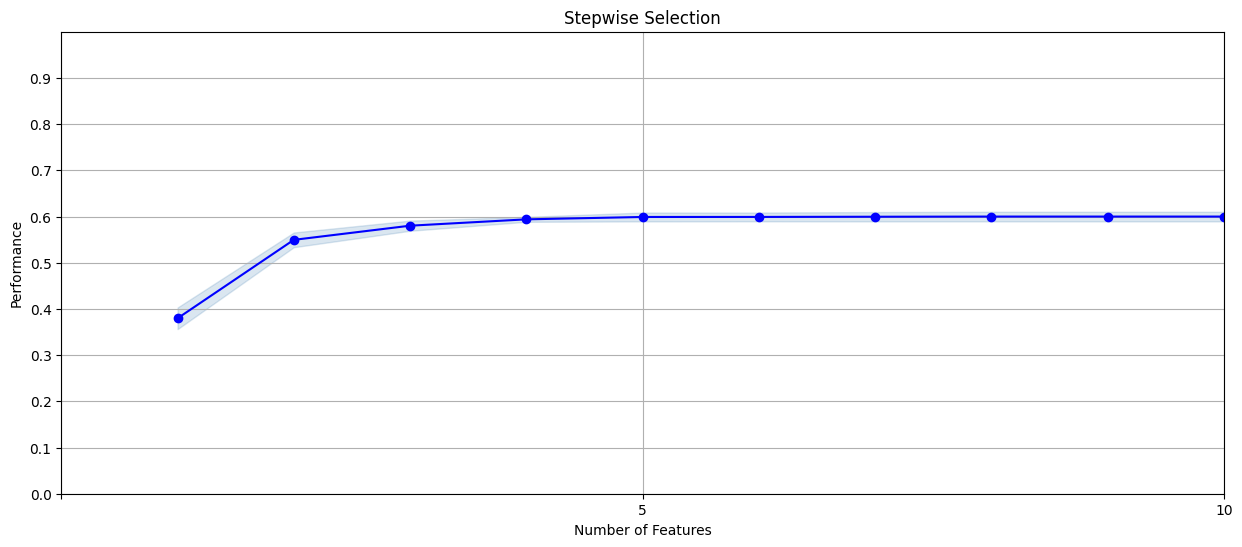

In [57]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [58]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [59]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))

In [60]:
ordered_vars_FS

feature_idx  \
1                                      (1,)   
2                                  (1, 205)   
3                             (1, 199, 205)   
4                          (0, 1, 199, 205)   
5                     (0, 1, 190, 199, 205)   
6                (0, 1, 190, 199, 200, 205)   
7             (0, 1, 5, 190, 199, 200, 205)   
8         (0, 1, 5, 14, 190, 199, 200, 205)   
9      (0, 1, 2, 5, 14, 190, 199, 200, 205)   
10  (0, 1, 2, 5, 8, 14, 190, 199, 200, 205)   

                                            cv_scores avg_score  \
1   [0.35361713241055104, 0.41028989292243406, 0.3...  0.379647   
2   [0.5270305562810134, 0.5620266388090885, 0.559...  0.549491   
3   [0.5646382867589449, 0.588926612692609, 0.5868...  0.580134   
4   [0.5876207887176809, 0.6006790284669626, 0.593...  0.593889   
5   [0.589710107077566, 0.6121702794463306, 0.5951...  0.599025   
6   [0.5899712718725516, 0.6121702794463306, 0.595...  0.599112   
7   [0.5886654478976234, 0.6129537738312876, 0.597...  0.599547   
8   [0.5886654478976234, 0.6137372682162444, 0.597...  0.599896   
9   [0.5886654478976234, 0.6137372682162444, 0.597...  0.599896   
10  [0.5886654478976234, 0.6137372682162444, 0.597...  0.599896   

                                        feature_names  ci_bound   std_dev  \
1                          (max_count_by_address_30,)   0.05258  0.023365   
2   (max_count_by_address_30, max_count_by_ssn_dob_7)   0.03582  0.015917   
3   (max_count_by_address_30, max_count_by_homepho...  0.024732   0.01099   
4   (max_count_by_fulladdress_30, max_count_by_add...  0.012025  0.005344   
5   (max_count_by_fulladdress_30, max_count_by_add...  0.021515  0.009561   
6   (max_count_by_fulladdress_30, max_count_by_add...  0.021325  0.009477   
7   (max_count_by_fulladdress_30, max_count_by_add...  0.022672  0.010075   
8   (max_count_by_fulladdress_30, max_count_by_add...  0.023405  0.010401   
9   (max_count_by_fulladdress_30, max_count_by_add...  0.023405  0.010401   
10  (max_count_by_fulladdress_30, max_count_by_add...  0.023405  0.010401   

     std_err  add variables in this order                    variable name  
1   0.016522                          1.0          max_count_by_address_30  
2   0.011255                          2.0           max_count_by_ssn_dob_7  
3   0.007771                          3.0         max_count_by_homephone_7  
4   0.003779                          4.0      max_count_by_fulladdress_30  
5   0.006761                          5.0              max_count_by_ssn_30  
6   0.006701                          6.0  fulladdress_homephone_day_since  
7   0.007124                          7.0            fulladdress_day_since  
8   0.007354                          8.0                  address_count_7  
9   0.007354                          9.0           max_count_by_address_7  
10  0.007354                         10.0       max_count_by_fulladdress_3

In [61]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [62]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1             max_count_by_address_30
2              max_count_by_ssn_dob_7
3            max_count_by_homephone_7
4         max_count_by_fulladdress_30
5                 max_count_by_ssn_30
6     fulladdress_homephone_day_since
7               fulladdress_day_since
8                     address_count_7
9              max_count_by_address_7
10         max_count_by_fulladdress_3
Name: variable name, dtype: object

In [63]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

filter score
variable                                                       
max_count_by_fulladdress_30                            0.359914
max_count_by_address_30                                0.359215
max_count_by_address_7                                 0.343335
max_count_by_fulladdress_7                             0.343052
address_day_since                                      0.334140
...                                                         ...
ssn_zip5_unique_count_for_address_14                   0.000002
ssn_lastname_unique_count_for_name_0                   0.000001
name_fulladdress_unique_count_for_zip5_30              0.000001
ssn_fulladdress_unique_count_for_ssn_firstname_60      0.000001
fulladdress_unique_count_for_address_0                 0.000000

[2241 rows x 1 columns]

In [64]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

Empty DataFrame
Columns: []
Index: [max_count_by_address_30, max_count_by_ssn_dob_7, max_count_by_homephone_7, max_count_by_fulladdress_30, max_count_by_ssn_30]

In [65]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [66]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

wrapper order                         variable  filter score
0              1          max_count_by_address_30      0.359215
1              2           max_count_by_ssn_dob_7      0.228401
2              3         max_count_by_homephone_7      0.232235
3              4      max_count_by_fulladdress_30      0.359914
4              5              max_count_by_ssn_30      0.241123
5              6  fulladdress_homephone_day_since      0.231844
6              7            fulladdress_day_since      0.333269
7              8                  address_count_7      0.301735
8              9           max_count_by_address_7      0.343335
9             10       max_count_by_fulladdress_3      0.329538

In [67]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['max_count_by_address_30',
 'max_count_by_ssn_dob_7',
 'max_count_by_homephone_7',
 'max_count_by_fulladdress_30',
 'max_count_by_ssn_30',
 'fulladdress_homephone_day_since',
 'fulladdress_day_since',
 'address_count_7',
 'max_count_by_address_7',
 'max_count_by_fulladdress_3',
 'record',
 'fraud_label']

In [68]:
filter_score

filter score
variable                                                       
max_count_by_fulladdress_30                            0.359914
max_count_by_address_30                                0.359215
max_count_by_address_7                                 0.343335
max_count_by_fulladdress_7                             0.343052
address_day_since                                      0.334140
...                                                         ...
ssn_zip5_unique_count_for_address_14                   0.000002
ssn_lastname_unique_count_for_name_0                   0.000001
name_fulladdress_unique_count_for_zip5_30              0.000001
ssn_fulladdress_unique_count_for_ssn_firstname_60      0.000001
fulladdress_unique_count_for_address_0                 0.000000

[2241 rows x 1 columns]

In [69]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 4min 44s, sys: 1min 33s, total: 6min 17s
Wall time: 6min 57s


(1000000, 2242)

In [70]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(1000000, 12)


In [71]:
df_keep.to_csv('vars_final.csv',index=False)

In [72]:
print("duration: ", dt.datetime.now() - start_time)

duration:  2:03:04.397034
